Load the packages.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
# Import the relevant functions from `sklearn.ensemble`, `sklearn.model_selection`, and `sklearn.metrics`.
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,\
classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier, plot_importance
#package to save models
import pickle


Load the data about Loans

In [3]:
loandf = pd.read_csv("Loan_Data.csv")
loandf = pd.DataFrame(loandf)

CLEANING PHASE

Display first few rows

In [4]:
loandf.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


Check for data type

In [5]:
loandf.dtypes

customer_id                   int64
credit_lines_outstanding      int64
loan_amt_outstanding        float64
total_debt_outstanding      float64
income                      float64
years_employed                int64
fico_score                    int64
default                       int64
dtype: object

Data types seem to be consistent.

Check for number of observations

In [6]:
loandf.count()

customer_id                 10000
credit_lines_outstanding    10000
loan_amt_outstanding        10000
total_debt_outstanding      10000
income                      10000
years_employed              10000
fico_score                  10000
default                     10000
dtype: int64

Each column has the same amount of observations.

Check for duplicates in customer_id (the only column that should have unique values)

In [7]:
#Define a function to count duplicates either in the entire df or in just 1 column
def count_duplicates(df, column=None):
    if column:
        return df.duplicated(subset=[column]).sum()
    else:
        duplicate_counts = {}
        for col in df.columns:
            duplicate_counts[col] = df.duplicated(subset=[col]).sum()
        return duplicate_counts

In [8]:
#Perform the computation
count_duplicates(loandf, column = "customer_id")

np.int64(0)

There are not duplicates (i.e each user is accounted for just 1 time).

Check for missing data

In [9]:
loandf.isna().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

No missing data.

Check if "default" contains just 0 and 1 (is a boolean data)

In [10]:
#check default col, it should be populated just by 0 and 1
loandf["default"].unique()

array([0, 1])

"deafult" contains just 0 and 1. 

Outliers check (IQR range method, boxplots)

In [11]:
#Define a function to check for outliers with IQR range or Z-score
def count_outliers(df, method='iqr', threshold=3):
    outlier_counts = {}

    for column in df.select_dtypes(include=[np.number]).columns:  # Only consider numeric columns
        if method == 'iqr':
            # IQR method
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))
        elif method == 'zscore':
            # Z-score method
            mean = df[column].mean()
            std_dev = df[column].std()
            z_scores = (df[column] - mean) / std_dev
            outliers = (z_scores.abs() > threshold)
        else:
            raise ValueError("Method must be 'iqr' or 'zscore'")
        
        outlier_counts[column] = outliers.sum()  # Count True values indicating outliers

    return outlier_counts

In [12]:
#Perform the check with iqr range techniques
count_outliers(loandf, method = "zscore")

{'customer_id': np.int64(0),
 'credit_lines_outstanding': np.int64(0),
 'loan_amt_outstanding': np.int64(41),
 'total_debt_outstanding': np.int64(143),
 'income': np.int64(30),
 'years_employed': np.int64(11),
 'fico_score': np.int64(26),
 'default': np.int64(0)}

In [13]:
#build a function to displays boxplot to better understand it.
def col_boxplots(df, columns=None):
    """
    Plots individual box plots for each specified column in the DataFrame.
    
    Parameters:
    - df: The DataFrame containing the data.
    - columns: List of columns to plot. If None, plots all numeric columns.
    """
    # If no columns are specified, use all numeric columns
    if columns is None:
        columns = df.select_dtypes(include='number').columns
    
    # Set up the subplots
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(8, num_columns * 2), squeeze=False)
    
    # Plot each column on a separate subplot
    for i, column in enumerate(columns):
        sns.boxplot(data=df, x=column, ax=axes[i, 0])
        axes[i, 0].set_title(f'Box plot of {column}')
        axes[i, 0].set_xlabel('Values')
        axes[i, 0].set_ylabel(column)
    
    plt.tight_layout()
    plt.show()

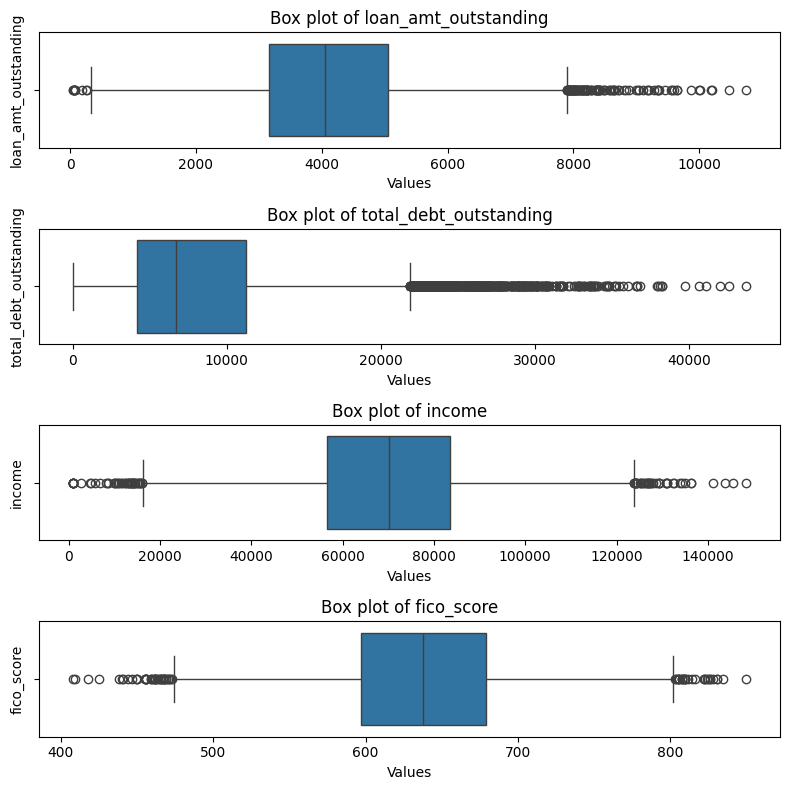

In [14]:
col_boxplots(loandf, columns = ["loan_amt_outstanding", 
                                "total_debt_outstanding",
                                "income",
                                "fico_score"])

In [15]:
#% of  rows with outliers respect to the total rows
((143+30+11+26)/10000)*100

2.1

The boxplots show there are some outliers in the dataset. Neverthless, as the z-score reveals, they are a small percentage of the dataset. Therefore, we are not going to remove them at the moment. Instead, we will drop them when it's time to develop a model that has the no-outlier assumption. 
Note that even if we drop the rows having outliers, we will end up losing just a small piece of information (around the 2.1% of the df, assuming outliers in different variables are in different rows)

To conclude, unuseful columns are dropped.

In [16]:
#drop not-useufl columns
loandf_subset = loandf.drop(columns=["customer_id"], axis = 1)

In [45]:
#save the new df
loandf_subset.to_csv("loandf_cleaned.csv", index = False)

Now the dataset is clean and analysis-ready. It is possible to move to the model building phase.

MODEL BUILDING

Prior to set up any kind of model, the dependent variables and the target must be defined. 

- The target variables is PD, i.e the deafult probability 
- The predictors are all the info avaialble, such as: outstanding credit line, outstanding loan amount, outstanding total debt, income, years employed, fico score, previous default.

The issue with the available data is that they do not have a PD column, hence our model must rely on a proxy for that column.

To make up for that, a 2-step approach will be employed:

- First, the target variable will be previous default. Different model will try to predict the probability of previous default based on the other available variables. To be sure to chose the best model, different models will be tested. 
In this phase, the previous default column acts as a "proxy variable". Indeed, to some extent, we are stating that if a customer defaulted before, it is more likley to default again in the future.

- Once the probability of previous defaults is computed, another model is trained. However, this time it will include the probability of previous default too. The target variable for this model is discussed later on.

- Finally, the expected loss is computed.

MODEL #1: PREDICTING PREVIOUS DEFAULT

In this model, the target variable is the "default" column. As with every ML model, some checkups must be done on the data.

The first one is target variable class balance, to understand if classes in "deault" are evenly distributed.

In [18]:
#define y and x
y = loandf_subset["default"]
x = loandf_subset.drop(columns = ["default"], axis = 1)

In [19]:
print("Number of observation in each class:")
print(y.value_counts())
print()
print("% of observation in each class:")
print(y.value_counts(normalize = True))

Number of observation in each class:
default
0    8149
1    1851
Name: count, dtype: int64

% of observation in each class:
default
0    0.8149
1    0.1851
Name: proportion, dtype: float64


Class balance is 81 - 19%. This is a little imbalanced. However, several ML models handle class imbalance fairly well.
Therefore, re-sampling is not implemented at the moment. Note. If the model leads to poor result, then it is possible to come bance and re-sample the target variable.

Multicollinearity should be inspected too. By printing the correlation matrix along with the VIF, correlation between variables is shown.

In [20]:
#define a function to compute correlation and VIF
def check_multicollinearity(df, method="correlation", threshold=0.7):
    """
    Checks for multicollinearity in the numerical columns of the DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        method (str): Method to use for checking multicollinearity.
                      "correlation" - Show correlation matrix with high correlations flagged.
                      "vif" - Compute Variance Inflation Factor (VIF) for numerical columns.
        threshold (float): Correlation threshold for flagging multicollinearity (for correlation method).
    
    Returns:
        pd.DataFrame or dict: Correlation matrix or VIF scores depending on the method.
    """
    # Select only numerical columns
    numerical_df = df.select_dtypes(include=[np.number])
    
    if method == "correlation":
        # Compute the correlation matrix
        corr_matrix = numerical_df.corr()
        # Flag correlations above the threshold
        high_corr = (corr_matrix.abs() >= threshold) & (corr_matrix != 1.0)
        return corr_matrix, high_corr
    
    elif method == "vif":
        # Compute VIF for each numerical column
        vif_data = pd.DataFrame()
        vif_data["feature"] = numerical_df.columns
        vif_data["VIF"] = [variance_inflation_factor(numerical_df.values, i) for i in range(len(numerical_df.columns))]
        return vif_data
    
    else:
        raise ValueError("Invalid method. Use 'correlation' or 'vif'.")

In [21]:
print("Correlation Matrix:")
check_multicollinearity(x, method="correlation", threshold=0.7)

Correlation Matrix:


(                          credit_lines_outstanding  loan_amt_outstanding  \
 credit_lines_outstanding                  1.000000              0.080249   
 loan_amt_outstanding                      0.080249              1.000000   
 total_debt_outstanding                    0.852210              0.397403   
 income                                    0.022272              0.835815   
 years_employed                           -0.087900             -0.158416   
 fico_score                               -0.258177             -0.031373   
 
                           total_debt_outstanding    income  years_employed  \
 credit_lines_outstanding                0.852210  0.022272       -0.087900   
 loan_amt_outstanding                    0.397403  0.835815       -0.158416   
 total_debt_outstanding                  1.000000  0.394397       -0.174353   
 income                                  0.394397  1.000000        0.001814   
 years_employed                         -0.174353  0.001814     

In [22]:
print("Correlation Matrix:")
check_multicollinearity(x, method="vif")

Correlation Matrix:


,feature,VIF
0,credit_lines_outstanding,10.948846
1,loan_amt_outstanding,35.088036
2,total_debt_outstanding,21.937163
3,income,59.930812
4,years_employed,11.896744
5,fico_score,22.404742


FEATURE ENGINEERING

Feature Selection

Feature Selection is crucial to avoid redundancies in the model. In this analysis, it has already been done by getting rid of "customer_id", as it is just a metadata.

All the other features are kept.

Feature Transformation

Transforming variables helps in having variables fitted for any kind of model. The major transformation this analysis does is standardization (i.e transforming each value within a feature so they collectively have a mean of zero and a standard deviation of one).

Note. Even though various ML do not need it, creating a dataset's copy with standardize data provides an alternative input for those models requiring scaled data. We will not scale the target variable, as it is boolean.
Note. Only training and validation data are scaled at the moment. If the "champion" model requires standardization, then testing data will be standardized too.

In [23]:
# Initialize the scaler
scaler = StandardScaler()
xScaled = scaler.fit_transform(x)
# Convert back to DataFrame and retain original column names and index
x_scaled = pd.DataFrame(xScaled, columns=x.columns, index=x.index)
# Check the first few rows of the scaled DataFrame
print(x_scaled.head())


   credit_lines_outstanding  loan_amt_outstanding  total_debt_outstanding  \
0                 -0.837960              0.747096               -0.724848   
1                  2.029409             -1.548375               -0.073967   
2                 -0.837960             -0.560509               -1.009696   
3                 -0.837960              0.427045               -0.938184   
4                 -0.264486             -1.979733               -1.048780   

     income  years_employed  fico_score  
0  0.398555        0.285425   -0.536770  
1 -2.161876       -1.629325   -1.080832  
2 -0.207919       -0.352825   -0.586230  
3  0.215083        0.285425   -0.421363  
4 -2.321314        0.923675   -0.108115  


Now, there is a dataset made of scaled variable. For models requiring scaling, this is the data input used.

Feature Extraction

Building features coming from existing ones is as useful as it gets in ML. Moreover, this is the phase where it possible to deal with multicollinearity.

In details, the added features are:

- Debt-to-income: this shows how much debt a user has relative to their income.
- Loan-to-income: this highlight how high is the loan relative to the user's income
- Debt-to-Credit: measures how much of their available credit a borrower has used.
- Debt-to-FICO: relates debt to credit worthiness. Note: A high debtToFico ratio indicates a borrower has taken on significant debt relative to their perceived ability to manage i

In [24]:
x["debtToIncome"] = x["total_debt_outstanding"] / x["income"]
x["loanToIncome"] = x["loan_amt_outstanding"] / x["income"]
x["debtToCredit"] = x["credit_lines_outstanding"] / x["total_debt_outstanding"]
x["debtToFico"] = x["total_debt_outstanding"] / x["fico_score"]

x_fe = x.drop(columns = ["income", "total_debt_outstanding", "loan_amt_outstanding", "credit_lines_outstanding", "fico_score"])
x_fe.head()

,years_employed,debtToIncome,loanToIncome,debtToCredit,debtToFico
0,5,0.050173,0.066909,0.000000,6.471853
1,2,0.308789,0.073510,0.000608,14.385931
2,4,0.030787,0.051058,0.000000,3.368490
3,5,0.033645,0.064105,0.000000,4.087795
4,6,0.075435,0.057395,0.000565,2.803211


In [25]:
check_multicollinearity(x_fe, method="vif")

,feature,VIF
0,years_employed,6.185309
1,debtToIncome,17.185579
2,loanToIncome,8.679512
3,debtToCredit,1.434469
4,debtToFico,12.488576


Multicollinearity is now drastically reduced. Therefore, the final set of variables is composed of:

- years_employed
- debtToIncome
- loanToIncome
- debtToCredit
- debtToFico

Models requiring scaling: for those models requiring scaling, extracted variables are standardized as well. 

In [26]:
# Initialize the scaler
scaler = StandardScaler()
x_feScaled = scaler.fit_transform(x_fe)
# Convert back to DataFrame and retain original column names and index
x_fescaled_df = pd.DataFrame(x_feScaled, columns=x_fe.columns, index=x_fe.index)
# Check the first few rows of the scaled DataFrame
print(x_fescaled_df.head())

   years_employed  debtToIncome  loanToIncome  debtToCredit  debtToFico
0        0.285425     -0.891868      0.703430     -0.449232   -0.666076
1       -1.629325      2.231588      1.323712      1.624112    0.029039
2       -0.352825     -1.126005     -0.786088     -0.449232   -0.938653
3        0.285425     -1.091487      0.439934     -0.449232   -0.875474
4        0.923675     -0.586763     -0.190548      1.479848   -0.988303


To test the model once it is built, testing data are a must-have. As such, the entire dataset must be split into training, validation and testing.
The chosen ratio is 80 (training) - 20(testing), and the class balance is kept.

In [27]:
#split the data into training-testing.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

In [28]:
#split the training data into training and validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                            stratify=y_train, random_state=42)

Furthermore, a function to compute evaluation metrics (accuracy, precison, recall and F1) is defined. 

In [29]:
def evaluate_model(model, X_val, y_val, model_name):
    """
    Evaluate a classification model and dynamically create variables for evaluation metrics.

    Args:
    - model: The trained model to evaluate.
    - X_val: Validation feature set.
    - y_val: Validation target set.
    - model_name: Custom name for the model.

    Returns:
    - A dictionary of metrics with model_name as a prefix.
    """
    # Predict the labels
    y_pred = model.predict(X_val)

    # Calculate evaluation metrics
    globals()[f"{model_name}_accuracy"] = accuracy_score(y_val, y_pred)
    globals()[f"{model_name}_precision"] = precision_score(y_val, y_pred, average='binary')
    globals()[f"{model_name}_recall"] = recall_score(y_val, y_pred, average='binary')
    globals()[f"{model_name}_f1"] = f1_score(y_val, y_pred, average='binary')

LOGISTIC REGRESSION

The easiest model employed is a logistic regression. Logistic regressions help in predicting outcomes for binary variables.

The first thing to do is to set the classifier.


In [30]:
#split scaled the data into training-testing.
Xscal_train, Xscal_test, yscal_train, yscal_test = train_test_split(x_fescaled_df, y, 
                                                                    test_size=0.20, 
                                                                    random_state=42, 
                                                                    stratify=y)

In [31]:
#split the training data into training and validation
Xscal_tr, Xscal_val, yscal_tr, yscal_val = train_test_split(Xscal_train, yscal_train,
                                                            test_size=0.2,
                                                            stratify=y_train,
                                                            random_state=42)

In [32]:
#logistic regression clf
logreg = LogisticRegression().fit(Xscal_tr, yscal_tr)

Consequently, it is possible to show the coefficients and the intercepts.

In [33]:
#show the coefficient
print(logreg.coef_)
#show the intercept
print(logreg.intercept_)

[[-0.88061366  7.55968845  0.14979402  0.32510159  0.87770456]]
[-8.50735608]


Once the coefficients are known, predictions can be made.

Both the outcome and the actual probability (that is actually the final target) are computed.

In [34]:
#predict the outcome
y_pred_log = logreg.predict(Xscal_val)

In [35]:
#show the actual prob
y_pred_logProb = logreg.predict_proba(Xscal_val)

The last step is to compute evalution metrics and save them in a df (named AccuracyScores) for comparison.

In [36]:
# Evaluation Metrics
print("Accuracy:", accuracy_score(yscal_val, y_pred_log))
print("Recall:", recall_score(yscal_val, y_pred_log))
print("Precision:", precision_score(yscal_val, y_pred_log))
print("f1 score:", f1_score(yscal_val, y_pred_log))

log_accuracy = accuracy_score(yscal_val, y_pred_log)
log_recall = recall_score(yscal_val, y_pred_log)
log_precision = precision_score(yscal_val, y_pred_log)
log_f1 = f1_score(yscal_val, y_pred_log) 

Accuracy: 0.98625
Recall: 0.9695945945945946
Precision: 0.9566666666666667
f1 score: 0.9630872483221476


In [37]:
#build a score table for model comparison
accuracyScores = pd.DataFrame({'Model': ["logistic_regression"],
                        'F1':  [log_f1],
                        'Recall': [log_recall],
                        'Precision': [log_precision],
                        'Accuracy': [log_accuracy]
                      }
                    )
accuracyScores

,Model,F1,Recall,Precision,Accuracy
0,logistic_regression,0.963087,0.969595,0.956667,0.98625


In [38]:
# Get feature importance
feature_importance = pd.DataFrame({"Feature": x_fescaled_df.columns, "Coefficient": logreg.coef_[0]})
print(feature_importance.sort_values(by="Coefficient", ascending=False))

          Feature  Coefficient
1    debtToIncome     7.559688
4      debtToFico     0.877705
3    debtToCredit     0.325102
2    loanToIncome     0.149794
0  years_employed    -0.880614


NAIVE BAYES

Naive Bayes is another fairly easy ML model that usually performs pretty well.

For its implementation, it is assumed data is normally distributed. If it turns out the NB is the champion model, this will be tested later.

As done above, set the classifier, fit the model, make predictions and compute & save evaluation metrics.

In [39]:
# Assign `nb` to be the appropriate implementation of Naive Bayes.
nb = naive_bayes.GaussianNB()
# Fit the model on your training data.
nb.fit(X_tr, y_tr)
# Apply your model to predict on your test data. Call this "y_pred".
y_pred_nb = nb.predict(X_val)

In [40]:
# accuracy
print('Accuracy:', '%.3f' % accuracy_score(y_val, y_pred_nb))
# precision
print('Precision:', '%.3f' % precision_score(y_val, y_pred_nb))
# recall
print('Recall:', '%.3f' % recall_score(y_val, y_pred_nb))
# f1 score
print('F1 Score:', '%.3f' % f1_score(y_val, y_pred_nb))
#accuracy
nb_accuracy = accuracy_score(y_val, y_pred_nb)
# precision
nb_precision = precision_score(y_val, y_pred_nb)
# recall
nb_recall = recall_score(y_val, y_pred_nb)
# f1 score
nb_f1 = f1_score(y_val, y_pred_nb)

Accuracy: 0.958
Precision: 0.840
Recall: 0.956
F1 Score: 0.894


In [41]:
#add those to the df
new_row1 = {
    'Model': "Naive_Bayes",
    'F1': nb_f1,
    'Recall': nb_recall,
    'Precision': nb_precision,
    'Accuracy': nb_accuracy
}
# Add the new row to the DataFrame using loc
accuracyScores.loc[len(accuracyScores)] = new_row1
# Check the updated DataFrame
accuracyScores

,Model,F1,Recall,Precision,Accuracy
0,logistic_regression,0.963087,0.969595,0.956667,0.986250
1,Naive_Bayes,0.894155,0.956081,0.839763,0.958125


Evaluation metrics show that the logistic regression performs way better than the NB model. This can be due to the assumption that data is normally distributed. 
Indeed, if that's not the case, NB could provide misleading (and wrong) results.

DECISION TREE

Decision Trees are another kind of model that may perform well doing this kind of tasks.

The workflow is the same as for the other models. However, this time it is necessary to tune the hyperparamters. That is done through GridSearch.

It is important to note that cross-validation (with 5 folds) is used to tune the model.

In [42]:
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=42)

In [43]:
# Assign a dictionary of hyperparameters to search over
tree_param = {'max_depth': [1,2,3,4,5,6,7,8,9,10, 50, 100],
             'min_samples_leaf': [2,3,4,5, 6, 7,8,9,10]}

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [44]:
# Instantiate the GridSearch
tree_clf = GridSearchCV(decision_tree, 
                   tree_param, 
                   scoring=scoring, 
                   cv=5, 
                   refit='f1')

# Fit the model
tree = tree_clf.fit(X_tr, y_tr)

KeyboardInterrupt: 

In [44]:
# Examine the best model from GridSearch
tree_clf.best_estimator_

DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, random_state=42)

The best combination for the decision tree model are:
max_dept = 8 & min_sample_leaf = 5

In [45]:
#check the best validation score
print("Best Avg. Validation Score: ", "%.4f" % tree_clf.best_score_)

Best Avg. Validation Score:  0.9673


In [46]:
evaluate_model(tree, X_val, y_val, "tree")

In [47]:
#add those to the df
new_row2 = {
    'Model': "Decision_Tree",
    'F1': tree_f1,
    'Recall': tree_recall,
    'Precision': tree_precision,
    'Accuracy': tree_accuracy
}
# Add the new row to the DataFrame using loc
accuracyScores.loc[len(accuracyScores)] = new_row2
# Check the updated DataFrame
accuracyScores

,Model,F1,Recall,Precision,Accuracy
0,logistic_regression,0.963087,0.969595,0.956667,0.986250
1,Naive_Bayes,0.894155,0.956081,0.839763,0.958125
2,Decision_Tree,0.980000,0.993243,0.967105,0.992500


RANDOM FOREST

More complex model could yield better results. As such, a random forest may be an optimal choice.

The process is the same as for a random tree: defining hyperparamters' range, tuning them, fit the model and check evaluation metrics.

In [48]:
#instantiate the classifier
rf = RandomForestClassifier(random_state=0)

In [49]:
cv_params = {'max_depth': [2,3,4,5], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4], #how many cols it should consider x tree
             'n_estimators': [75, 100, 125, 150] #how many trees it should fit
             }  

In [50]:
#GridSearch the model employing f1 as primary method
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')
# Results saved in `rf_cv_model.pickle` below
#rf_cv.fit(X_tr, y_tr)

In [51]:
#define a path where the saved model must go (the model folder in the main folder)
path = "/Users/lucaalbertini/Desktop/JPMorgan_Job/task3/models/"

In [52]:
# Pickle the model
#with open(path+'rf_model.pickle', 'wb') as to_write:
 #  pickle.dump(rf_cv, to_write)

In [53]:
with open(path+'rf_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

In [54]:
#show rf best parameters
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}

In [55]:
#show the best f1 score
rf_cv.best_score_

np.float64(0.9723957230428635)

In [56]:
#compute evaluation metrics
evaluate_model(rf_cv, X_val, y_val, "rf")

In [57]:
#add the rf parameters to the score table
#add those to the df
new_row2 = {
    'Model': "Random_forest",
    'F1': rf_f1,
    'Recall': rf_recall,
    'Precision': rf_precision,
    'Accuracy': rf_accuracy
}
# Add the new row to the DataFrame using loc
accuracyScores.loc[len(accuracyScores)] = new_row2
# Check the updated DataFrame
accuracyScores

,Model,F1,Recall,Precision,Accuracy
0,logistic_regression,0.963087,0.969595,0.956667,0.986250
1,Naive_Bayes,0.894155,0.956081,0.839763,0.958125
2,Decision_Tree,0.980000,0.993243,0.967105,0.992500
3,Random_forest,0.976510,0.983108,0.970000,0.991250


XGBOOSTING

The last possibility is to opt for a XGBoost model.

As before, it must be instantiated, fitted and tuned. Evaluation metrics are computed too.

In [58]:
#instantiate the model
xgb = XGBClassifier(objective='binary:logistic', random_state=42, reg_alpha=0.1, reg_lambda=1.0)

#define the parameters
xgb_params = {'max_depth': [4,5,6], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [50, 75, 100, 125]
             }    
#define the gridsearch
xgb_cv = GridSearchCV(xgb, xgb_params, scoring=scoring, cv=5, refit='f1')

In [59]:
#fit the model
#xgb_cv.fit(X_tr, y_tr)

In [60]:
# Pickle the model
#with open(path + 'xgb_model.pickle', 'wb') as to_write:
 #   pickle.dump(xgb_cv, to_write)
    
# Open pickled Boosting model
with open(path+'xgb_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

In [61]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 100}

In [62]:
evaluate_model(xgb_cv, X_val, y_val, "xgb")

In [63]:
#add the xgb parameters to the score table
#add those to the df
new_row4 = {
    'Model': "XGBoosting",
    'F1': xgb_f1,
    'Recall': xgb_recall,
    'Precision': xgb_precision,
    'Accuracy': xgb_accuracy
}
# Add the new row to the DataFrame using loc
accuracyScores.loc[len(accuracyScores)] = new_row4
# Check the updated DataFrame
accuracyScores

,Model,F1,Recall,Precision,Accuracy
0,logistic_regression,0.963087,0.969595,0.956667,0.986250
1,Naive_Bayes,0.894155,0.956081,0.839763,0.958125
2,Decision_Tree,0.980000,0.993243,0.967105,0.992500
3,Random_forest,0.976510,0.983108,0.970000,0.991250
4,XGBoosting,0.988196,0.989865,0.986532,0.995625


The model performing better is XGBoosting. As such, it will be the model employed to estimate PD.

Delving more in model perfromances helps in undertsand its error margin. Therefore, Confusion Matrix and feature importance are computed.

In [64]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 

    # Make predictions on (x) test data
    model_pred = model.predict(x_data)
    
    # Compute values for confusion matrix
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    
    # Create display of confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)

    # Plot confusion matrix
    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    
    # Display plot
    plt.show()

XGB confusion Matrix:


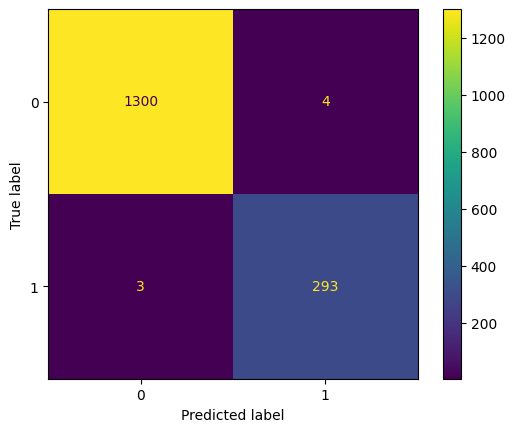

In [65]:
print("XGB confusion Matrix:")
conf_matrix_plot(xgb_cv, X_val, y_val)

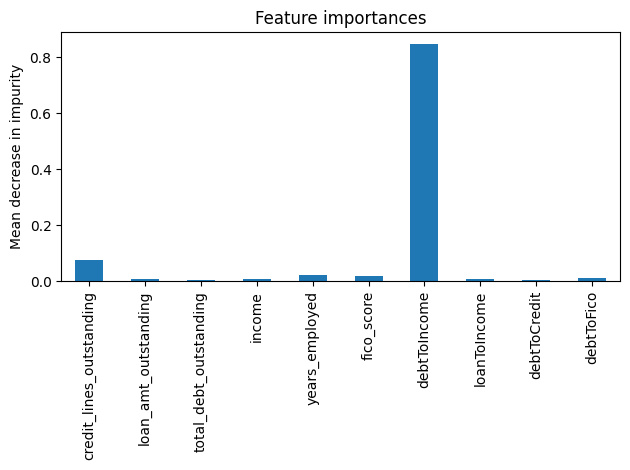

In [66]:
#feature importance 
importances = xgb_cv.best_estimator_.feature_importances_
xgb_importances = pd.Series(importances, index=X_val.columns)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [67]:
print(xgb_importances)

credit_lines_outstanding    0.075672
loan_amt_outstanding        0.005937
total_debt_outstanding      0.002414
income                      0.006961
years_employed              0.020396
fico_score                  0.018188
debtToIncome                0.847034
loanToIncome                0.008008
debtToCredit                0.004866
debtToFico                  0.010525
dtype: float32


The results of the XGBoost model reveal that debtToIncome is the most influential feature, with a feature importance of 84.7%, significantly outweighing other variables such as credit_lines_outstanding (7.6%) and years_employed (2.0%). Other features like loan_amt_outstanding, total_debt_outstanding, and debtToCredit exhibit minimal contributions, with feature importance values below 1%.

In terms of accuracy, the model demonstrates high performance, with only 7 total misclassifications—3 false negatives and 4 false positives. This indicates the model is robust at predicting defaults while maintaining a low error rate, with misclassification impacting a small fraction of predictions.

Further refinement could focus on assessing the necessity of low-importance features to streamline the model without sacrificing accuracy.

TEST DATA PERFORMANCES

In the end, the most must be assessed on test data.

In [68]:
evaluate_model(xgb_cv, X_test, y_test, "xgb_test")

In [69]:
test_metrics = pd.DataFrame(
    {
    'Model': ["Xgb_testing"],
    'F1': [xgb_test_f1],
    'Recall': [xgb_test_recall],
    'Precision': [xgb_test_precision],
    'Accuracy': [xgb_test_accuracy]
    }
)
test_metrics

,Model,F1,Recall,Precision,Accuracy
0,Xgb_testing,0.993197,0.986486,1.0,0.9975


XGB on testing data confusion Matrix:


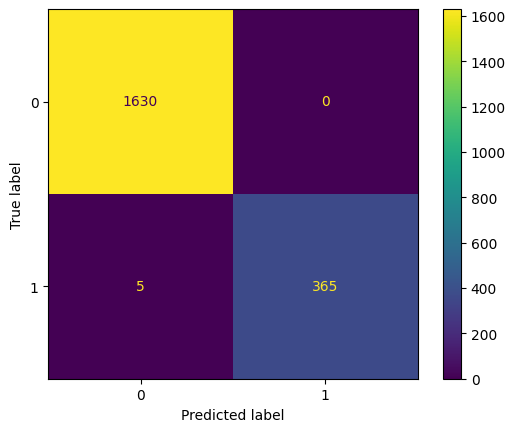

In [70]:
print("XGB on testing data confusion Matrix:")
conf_matrix_plot(xgb_cv, X_test, y_test)

The model achieves outstanding classification, demonstrating its reliability and accuracy in predicting defaults.
By emphasizing the Debt-to-Income Ratio, the model aligns with intuitive risk assessment principles.
The absence of false positives ensures customers are not unfairly flagged, minimizing negative customer experiences. Plus, only Only 5 customers who would default were not identified by the model.

Final Recommendation:
This model is robust for deployment, offering high reliability in identifying potential defaulters. However, continuous monitoring and retraining should be performed as new data becomes available to ensure sustained performance.

PROBABILITY OF DEFAULT

To conclude, it is time to add the main target of our analysis: the default probability. It will be computed for the entire dataset (test + validation + train).

In [73]:
# Combine the datasets
X_combined = pd.concat([X_tr, X_val, X_test], axis=0)
y_combined = pd.concat([y_tr, y_val, y_test], axis=0)
# Predict probabilities for the entire dataset
combined_probabilities = xgb_cv.predict_proba(X_combined)[:, 1]  # Default class probabilities
# Create a DataFrame to store results
DefaultProb = X_combined.copy()  # Copy feature data
DefaultProb['Probability_of_Default'] = combined_probabilities  # Add default probabilities
DefaultProb['Prediction'] = xgb_cv.predict(X_combined)  # Add predicted classes
DefaultProb['Actual'] = y_combined.values  # Add actual target values
# Check the first few rows
DefaultProb.head()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,debtToIncome,loanToIncome,debtToCredit,debtToFico,Probability_of_Default,Prediction,Actual
6988,5,3010.972512,15315.632280,50249.54978,4,597,0.304791,0.059920,0.000326,25.654325,0.999645,1,1
8376,0,2805.670759,1654.650582,42902.60256,4,618,0.038568,0.065396,0.000000,2.677428,0.000074,0,0
3594,0,7133.562392,4477.283469,80240.72660,3,684,0.055798,0.088902,0.000000,6.545736,0.000127,0,0
3836,0,3452.535598,3620.915701,67068.24401,6,724,0.053989,0.051478,0.000000,5.001265,0.000055,0,0
3745,0,3596.709920,5847.202148,74431.14744,5,581,0.078559,0.048323,0.000000,10.064031,0.000070,0,0


In [74]:
#save the df
DefaultProb.to_csv("Default_Probability.csv")